In [1]:
import os
import sys
from tabulate import tabulate
from IPython.display import display,HTML,Markdown
from dataclasses import dataclass
from typing import List,Tuple

import matplotlib
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('png')
plt.rcParams['figure.dpi'] = 120
import base64, io
import html
import skimage.io
import numpy as np
import json
import copy

nb_path = !pwd
proj_path = os.path.split(nb_path[0])[0]

sys.path.append(proj_path)

# make sure that the API key is present
assert os.path.exists('api_key.json')
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = os.path.join(nb_path[0], 'api_key.json')

from data_graph_matching.graph_content_classification import model_labels

In [2]:
from data_graph_matching.pipeline_extend import ppl_google_text_ocr
from data_graph_matching.pipeline import (ppl_batch_get_graph_component,
                                            ppl_get_text_alignment,
                                            ppl_get_legend_color,
                                            ppl_fine_tune_figure_region,
                                            ppl_batch_get_figure_content_classification,
                                            ppl_parse_graph,
                                            ppl_match_dataset)
from data_graph_matching.pipeline import run_pipeline_batched

In [3]:
# get the list of files in a directory
def load_file_list(path, ext):
    ret = []
    for p in filter(lambda x: x.endswith(ext), os.listdir(path)):
        ret.append(os.path.join(path, p))
    return ret

# a function to help sort the filenames by graph/dataset index
def num_sort_key(p):
    fn = os.path.split(p)[1]
    ret = None

    name = os.path.splitext(fn)[0]
    if '_' in name:
        try:
            ret = int(name.partition('_')[2])
        except Exception:
            pass
    
    if ret is None:
        return 0x7FFFFFFF
    else:
        return ret

# acquire lists of images and datasets
list_of_images = load_file_list(os.path.join(proj_path, 'example', 'graph'), '.png')
list_of_datasets = load_file_list(os.path.join(proj_path, 'example', 'dataset'), '.csv')

# sort the list of images for reproducibility
list_of_images.sort(key=num_sort_key)

## Pipeline Definition

In [4]:
# define a function to inject dataset matching candidates
def ppl_inject_dataset_candidate(batch_config):
    batch_config['dataset_candidates'] = list_of_datasets

# define our pipeline
pipeline_steps = [
    ppl_google_text_ocr,
    ppl_batch_get_graph_component,
    ppl_get_text_alignment,
    ppl_get_legend_color,
    ppl_fine_tune_figure_region,
    ppl_batch_get_figure_content_classification,
    ppl_parse_graph,
    ppl_inject_dataset_candidate,
    ppl_match_dataset
]

In [5]:
# run the pipeline
batch_results = run_pipeline_batched(pipeline_steps, list_of_images, batch_size=32)

running batch 1/1 (batch size=8)
using Google OCR API for text detection
localizing main figure content and color bar
performing text alignment
finding color for legends
fine tuning figure region localization
classifying figure content
parsing graph information
matching datasets


## Result Analysis

In [34]:
@dataclass
class PipelineResult:
    filename : str
    step_log : list
    step_result : list
    step_name : List[str]

    def find_step_index(self, name, raise_err=True):
        for i, n in enumerate(self.step_name):
            if name in n:
                return i
        if raise_err:
            raise RuntimeError(f'unable to find the step index for step name "{name}"')
        else:
            return -1

    def get_step_result(self, name):
        step_ind = self.find_step_index(name)
        return self.step_result[step_ind]
    
    def get_step_log(self, name):
        step_ind = self.find_step_index(name)
        return self.step_log[step_ind]


class ResultAnalyzer:

    def __init__(self, batch_results):
        self.results = batch_results

        self.num_images = 0
        self.img_lookup = dict()
        for batch_ind, batch in enumerate(batch_results):
            for img_ind in range(len(batch['filenames'])):
                self.img_lookup[self.num_images] = (batch_ind, img_ind)
                self.num_images += 1

        dataset_info_path = os.path.join(proj_path, 'example', 'dataset_info.json')
        self.dataset_info = None
        if os.path.exists(dataset_info_path):
            with open(dataset_info_path) as infile:
                self.dataset_info = json.load(infile)

        self.train_dataset_lut = dict()
        for item in self.dataset_info['split']['train']['graph']:
            self.train_dataset_lut[item['name']] = item['answer']


    # return the total number of images
    def get_num_images(self):
        return self.num_images

    def get_pipeline_results(self, image_ind):
        batch_ind, sub_id = self.img_lookup[image_ind]
        target_batch = self.results[batch_ind]
        
        filename = target_batch['filenames'][sub_id]

        num_steps = len(target_batch['results'])
        step_name = []
        step_result = []
        step_log = []
        for i in range(num_steps):
            step_name.append(target_batch['results'][i]['step_name'])
            step_result.append(target_batch['results'][i]['result'][sub_id])
            logs = dict()
            for key, val in target_batch['logs'][i].items():
                if isinstance(val, (list,tuple)):
                    item = val[sub_id]
                    if isinstance(item, str):
                        if len(item) > 0:
                            logs[key] = item
                    else:
                        logs[key] = item
                    
            step_log.append(logs)

        ret = PipelineResult(filename=filename,
            step_log=step_log,
            step_result=step_result,
            step_name=step_name)

        return ret

    @staticmethod
    def _save_matplotlib_image_as_html(alt_data=''):
        bio = io.BytesIO()
        plt.savefig(bio, bbox_inches='tight', format='png')
        b64 = base64.b64encode(bio.getbuffer()).decode()
        src = 'data:image/png;base64,' + b64
        img_element = f'<img src="{src}" alt="{alt_data}"/>'
        plt.close()
        return img_element

    @staticmethod
    def _html_element(tag, data, escape=True):
        return '<{tag}>{data}</{tag}>'.format(
                tag=tag,
                data=html.escape(data) if escape else data
            )

    def show_result(self, image_ind):
        pipeline_result = self.get_pipeline_results(image_ind)

        result_sections = []

        section = []
        section.append(self._html_element('h3', 'Input Figure'))
        # load input image
        img = skimage.io.imread(pipeline_result.filename)
        plt.imshow(img)
        section.append(self._save_matplotlib_image_as_html())
        result_sections.append(section)

        step_ind = pipeline_result.find_step_index('get_text_ocr', raise_err=False)
        if step_ind != -1:
            step_result = pipeline_result.step_result[step_ind]
            if step_result is not None:
                section = []
                section.append(self._html_element('h3', 'Step Result: Text Extraction'))
                section.append(self._html_element('p', 'The text bounding boxes are shown as below:'))

                plt.imshow(img)
                # skip the first global bounding box
                for item in step_result[1:]:
                    vs = np.asarray(item['v'])
                    plt.plot(vs[:, 0], vs[:, 1], color='red')
                    plt.plot(vs[(-1,0), 0], vs[(-1,0), 1], color='red')

                section.append(self._save_matplotlib_image_as_html())
                result_sections.append(section)

        # use the fine-tuned figure body localization result, if available
        step_result = None
        step_ind = pipeline_result.find_step_index('fine_tune_figure_region', raise_err=False)
        if step_ind == -1:
            step_ind == pipeline_result.find_step_index('get_graph_component', raise_err=False)
            if step_ind != -1:
                step_result = pipeline_result.step_result[step_ind]
        else:
            step_result = pipeline_result.step_result[step_ind]
        

        if step_result is not None:
            section = []
            section.append(self._html_element('h3', 'Step Result: Figure Body Localization'))
            section.append(self._html_element('p', 'The figure body is shown as below:'))

            j_min, i_min, j_max, i_max = step_result
            j_min, j_max = np.clip(np.round([j_min, j_max]), 0, img.shape[1])
            i_min, i_max = np.clip(np.round([i_min, i_max]), 0, img.shape[0])
            figure_body = img[i_min:i_max, j_min:j_max]

            if figure_body.size > 0:
                plt.imshow(figure_body)
                section.append(self._save_matplotlib_image_as_html())
                result_sections.append(section)


        step_ind = pipeline_result.find_step_index('get_text_alignment', raise_err=False)
        if step_ind != -1:
            step_result = pipeline_result.step_result[step_ind]
            if step_result is not None:
                section = []
                section.append(self._html_element('h3', 'Step Result: Text Alignment'))
                section.append(self._html_element('p', 'The text alignment line(s) are shown as below:'))

                plt.imshow(img)

                for cluster in step_result['cluster']:
                    all_coords = np.asarray([x['text']['v'][cluster['vertex_index']] for x in cluster['text']])
                    mean_coords = np.mean(all_coords, axis=0)

                    if cluster['coordinate_index'] == 0:
                        plt.plot(all_coords[:, 0], [mean_coords[1]] * all_coords.shape[0], color='red')
                    else:
                        plt.plot([mean_coords[0]] * all_coords.shape[0], all_coords[:, 1], color='red')

                section.append(self._save_matplotlib_image_as_html())

                # section.append(self._save_matplotlib_image_as_html())
                result_sections.append(section)

        legend_color_section = None
        step_ind = pipeline_result.find_step_index('get_legend_color', raise_err=False)
        if step_ind != -1:
            step_result = pipeline_result.step_result[step_ind]
            if step_result is not None and len(step_result) > 0:
                section = []
                section.append(self._html_element('h3', 'Step Result: Legend Extraction'))

                li = []
                for item in step_result:
                    legend_text, legend_color, legend_bbox = item
                    hex_color = matplotlib.colors.to_hex(np.asarray(legend_color) / 255.0)
                    li.append('<li><span style="background-color:{};">&ensp;&ensp;</span> {}</li>'.format(
                            hex_color,
                            html.escape(legend_text)
                            ))
                
                section.append(self._html_element('ul', '\n'.join(li), False))
                legend_color_section = section

        step_ind = pipeline_result.find_step_index('content_classification', raise_err=False)
        if step_ind != -1:
            step_result = pipeline_result.step_result[step_ind]
            if step_result is not None:
                section = []
                section.append(self._html_element('h3', 'Step Result: Figure Type Classification'))
                section.append(self._html_element('p', 'The figure type is classified to be <strong>{}</strong>'.format(html.escape(step_result)), 
                    False))

                if step_result != 'heatmap' and legend_color_section is not None:
                    result_sections.append(legend_color_section)
            
                log = pipeline_result.step_log[step_ind]

                if 'logit' in log:
                    logits = np.asarray(log['logit'])
                    plt.bar(np.arange(logits.size), logits)
                    plt.gca().set_yscale('log')
                    plt.xticks(np.arange(logits.size), model_labels, rotation=45)
                    plt.title('Figure Type Classification Logits')
                    section.append(self._save_matplotlib_image_as_html())
                    
                result_sections.append(section)
        

        step_ind = pipeline_result.find_step_index('parse_graph', raise_err=False)
        if step_ind != -1:
            step_result = pipeline_result.step_result[step_ind]
            if step_result is not None and 'parse_result' in step_result:
                
                # axis extraction step
                if 'xticks' in step_result and 'yticks' in step_result:
                    xt = step_result['xticks']
                    yt = step_result['yticks']
                    key_name = 'transform_param'
                    if key_name in xt and key_name in yt:
                        xt = xt[key_name]
                        yt = yt[key_name]
                        section = []
                        section.append(self._html_element('h3', 'Step Result: Axis Extraction'))
                        table = [['', 'x-axis', 'y-axis']]
                        table.append(['alpha', xt[0], yt[0]])
                        table.append(['beta', xt[1], yt[1]])
                        table.append(['gamma', xt[2], yt[2]])
                        section.append(tabulate(table, tablefmt='html'))
                        result_sections.append(section)


                section = []
                section.append(self._html_element('h3', 'Step Result: Data Extraction'))
                section.append(self._html_element('pre', json.dumps(step_result['parse_result'], indent=1)))
                result_sections.append(section)

        

        step_ind = pipeline_result.find_step_index('match_dataset', raise_err=False)
        if step_ind != -1:
            step_result = pipeline_result.step_result[step_ind]
            if step_result is not None and len(step_result) > 0:
                section = []
                section.append(self._html_element('h3', 'Step Result: Dataset Matching'))
                section.append(self._html_element('pre', repr(step_result[0])))
                result_sections.append(section)

        
        if self.train_dataset_lut is not None:
            graph_key = None
            try:
                graph_key = num_sort_key(pipeline_result.filename)
            except:
                pass

            if graph_key is not None:
                answer = self.train_dataset_lut.get('graph_'+repr(graph_key), None)
                if answer is not None:
                    section = []
                    section.append(self._html_element('h3', 'Ground Truth'))
                    section.append(self._html_element('p', 'The ground truth is {}'.format(answer)))
                    result_sections.append(section)

        table = [['Step Name', 'Log Name', 'Log Data']]
        for i in range(len(pipeline_result.step_name)):
            log = pipeline_result.step_log[i]
            if len(log) > 0:
                for key, val in log.items():
                    if isinstance(val, str):
                        table.append([pipeline_result.step_name[i], key, val])
        if len(table) > 1:
            section = []
            section.append(self._html_element('h3', 'Pipeline Log'))
            section.append(tabulate(table, tablefmt='html'))
            result_sections.append(section)
        

        output_html = '\n\n'.join(['\n'.join(x) for x in result_sections])
        display(HTML(output_html))

### Result Analyzer Instance

In [35]:
res_analyzer = ResultAnalyzer(batch_results)

,x-axis,y-axis
alpha,98.0065247265295,609.5799628523056
beta,-29.983261822932192,-399.61123135076883
gamma,12.914918509422005,-0.6579235514824169
Step Name,Log Name,Log Data
get_graph_component,detail,found figure content in detection step
get_text_alignment,process_criteria_log,OK
get_text_alignment,detail,OK
get_legend_color,process_criteria_log,OK
get_legend_color,detail,OK
fine_tune_figure_region,process_criteria_log,OK

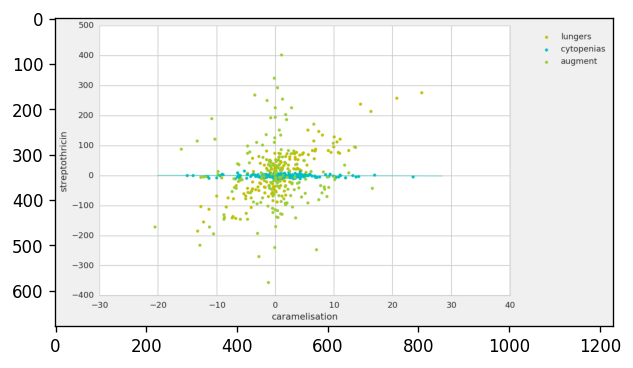
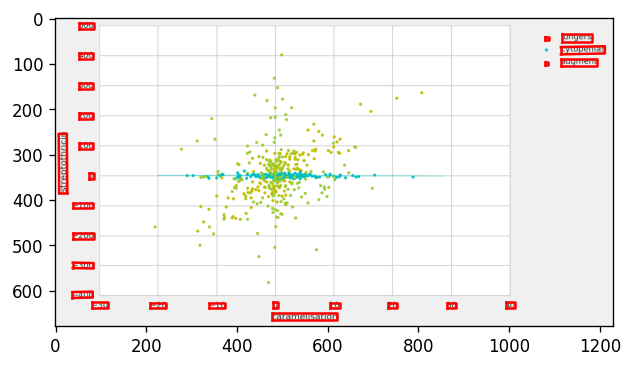
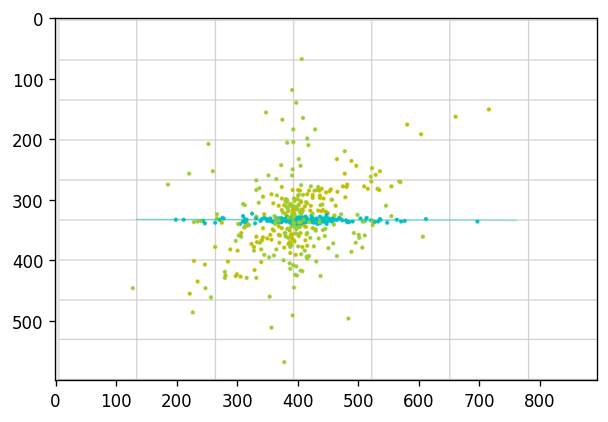
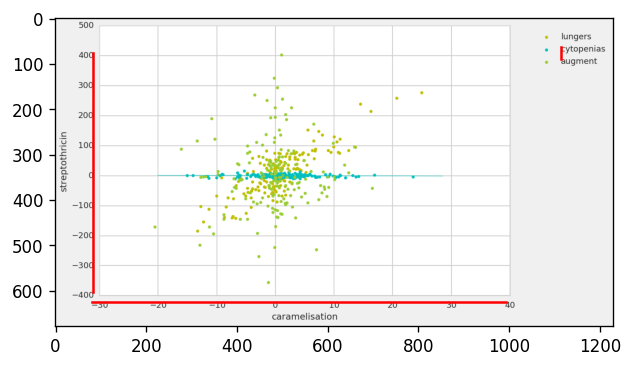
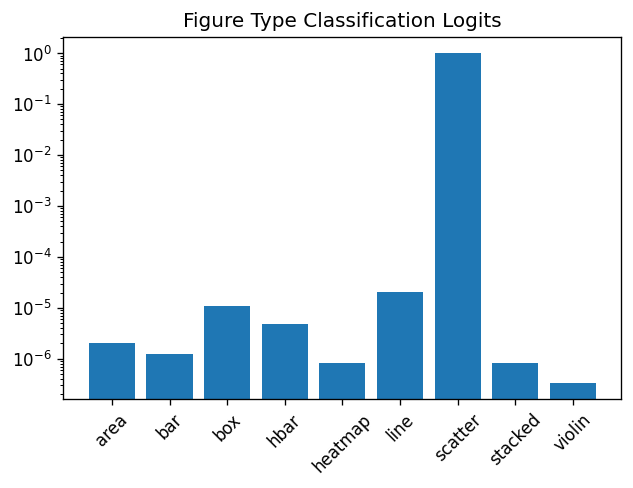

In [36]:
res_analyzer.show_result(7)